##### Copyright 2018 The TensorFlow Authors.

##**Disaster events : Text classification with an RNN**##



<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup ##

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import the packages

import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
# Download the data

import pandas as pd
dataset = pd.read_csv('/content/Project Dataset.csv')

In [ ]:
# Check the dataset

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


## Data preparation ##

In [ ]:
# We remove id, keyword and location columns

dataset = dataset.drop(columns=['id', 'keyword', 'location'])

In [ ]:
# Initalize the graph function

import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
# We check again the dataset with the removed columns

dataset.head()

,text,target
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,Telangana: Section 144 has been imposed in Bha...,1
2,Arsonist sets cars ablaze at dealership https:...,1
3,Arsonist sets cars ablaze at dealership https:...,1
4,"""Lord Jesus, your love brings freedom and pard...",0


In [ ]:
# We transform the data in DataFrame

dataset = pd.DataFrame(dataset)
Text = dataset["text"]
Target = dataset["target"]

# We split the data into train and test samples

from sklearn.model_selection import train_test_split

text_train, text_test, target_train, target_test = train_test_split(Text, Target, test_size=0.15,stratify=Target)

text_train_tensor = tf.convert_to_tensor(text_train,dtype=tf.string)
target_train_tensor = tf.convert_to_tensor(target_train,dtype=tf.int32)

text_test_tensor = tf.convert_to_tensor(text_test,dtype=tf.string)
target_test_tensor = tf.convert_to_tensor(target_test,dtype=tf.int32)




In [ ]:
Train_dataset = tf.data.Dataset.from_tensor_slices((text_train_tensor, target_train_tensor))
Test_dataset = tf.data.Dataset.from_tensor_slices((text_test_tensor, target_test))

In [ ]:
#  We associated the text with its labels

for example, label in Train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'you got a smoke? ...got gum https://t.co/38rLncz6o3'
label:  0


In [ ]:
# We create batches of text and labels pairs

BUFFER_SIZE = 11370
batch_size = 30

In [ ]:
Train_dataset = Train_dataset.shuffle(BUFFER_SIZE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
Test_dataset = Test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in Train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Burning up firee ~~ #ALABTopSpotONMYX #PUSHAwardsATIN #SB19atWMA2020'
 b'Have you seen our current exhibition yet?! An explosion of colour from pupils at with their exhibition \xe2\x80\x9cM\xe2\x80\xa6'
 b"Blanket secrecy' surrounds Australian weapons sales to countries accused of war crimes https://t.co/ko6nqZs61d"]

labels:  [0 0 1]


In [ ]:
# We create the label encoder using TextVectorization

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(Train_dataset.map(lambda text, target: text))

In [ ]:
# We display the first 20 tokens

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'a', 'of', 'in', 'and', 'is', 'i', 'for',
       'on', 'you', 'that', 'this', 'with', 'it', 'are', 'my', 'at'],
      dtype='<U12')

In [ ]:
# Then we encode the text into indices 

encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[181,  47,   1,   1,   1,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 21,  12, 419,  56, 662,   1, 265,  30, 685,   5,   1,  22,   1,
         19,  15,  59,   1,   1,   0,   0,   0,   0,   0,   0,   0],
       [  1,   1,   1, 243, 521,   1,   3,   1,   1,   5, 209,   1,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Burning up firee ~~ #ALABTopSpotONMYX #PUSHAwardsATIN #SB19atWMA2020'
Round-trip:  burning up [UNK] [UNK] [UNK] [UNK]                   

Original:  b'Have you seen our current exhibition yet?! An explosion of colour from pupils at with their exhibition \xe2\x80\x9cM\xe2\x80\xa6'
Round-trip:  have you seen our current [UNK] yet an explosion of [UNK] from [UNK] at with their [UNK] [UNK]       

Original:  b"Blanket secrecy' surrounds Australian weapons sales to countries accused of war crimes https://t.co/ko6nqZs61d"
Round-trip:  [UNK] [UNK] [UNK] australian weapons [UNK] to [UNK] [UNK] of war [UNK] [UNK]            



## RNN Models

In [ ]:
## FIRST MODEL ##

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding

sample_text = ('Thank you to everyone who has bought a charity phone case so far to support the wildlife victims of Australia’s worst ever…')
predictions = model(np.array([sample_text]))
print(predictions[0])

tf.Tensor([0.0116032], shape=(1,), dtype=float32)


In [ ]:
# predict on a sample text with padding

padding = "you" * 2000
predictions = model(np.array([sample_text, padding]))
print(predictions[0])

tf.Tensor([0.0116032], shape=(1,), dtype=float32)


In [ ]:
sample_text = ('Thank you to everyone who has bought a charity phone case so far to support the wildlife victims of Australia’s worst ever…')
predictions = model(np.array([sample_text]))

In [ ]:
# We configure the Keras model to the training process:

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# We train our first model

history = model.fit(Train_dataset.repeat(),
                    steps_per_epoch=int(9096/batch_size),
                    epochs=10,
                    validation_data=Test_dataset.repeat(),
                    validation_steps=int(2274/batch_size))

Epoch 1/10
303/303 [==============================] - 22s 41ms/step - loss: 0.5392 - accuracy: 0.8133 - val_loss: 0.4685 - val_accuracy: 0.8139
Epoch 2/10
303/303 [==============================] - 9s 30ms/step - loss: 0.4150 - accuracy: 0.8150 - val_loss: 0.3790 - val_accuracy: 0.8188
Epoch 3/10
303/303 [==============================] - 9s 30ms/step - loss: 0.3259 - accuracy: 0.8676 - val_loss: 0.3346 - val_accuracy: 0.8776
Epoch 4/10
303/303 [==============================] - 9s 30ms/step - loss: 0.2923 - accuracy: 0.8840 - val_loss: 0.3261 - val_accuracy: 0.8758
Epoch 5/10
303/303 [==============================] - 10s 32ms/step - loss: 0.2624 - accuracy: 0.8962 - val_loss: 0.3226 - val_accuracy: 0.8704
Epoch 6/10
303/303 [==============================] - 9s 31ms/step - loss: 0.2636 - accuracy: 0.8968 - val_loss: 0.3340 - val_accuracy: 0.8718
Epoch 7/10
303/303 [==============================] - 10s 32ms/step - loss: 0.2523 - accuracy: 0.9023 - val_loss: 0.3293 - val_accuracy: 0.8

In [ ]:
test_loss, test_acc = model.evaluate(Test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

57/57 [==============================] - 1s 11ms/step - loss: 0.3459 - accuracy: 0.8787
Test Loss: 0.34587064385414124
Test Accuracy: 0.8786635398864746


(0.0, 0.5543326236307621)

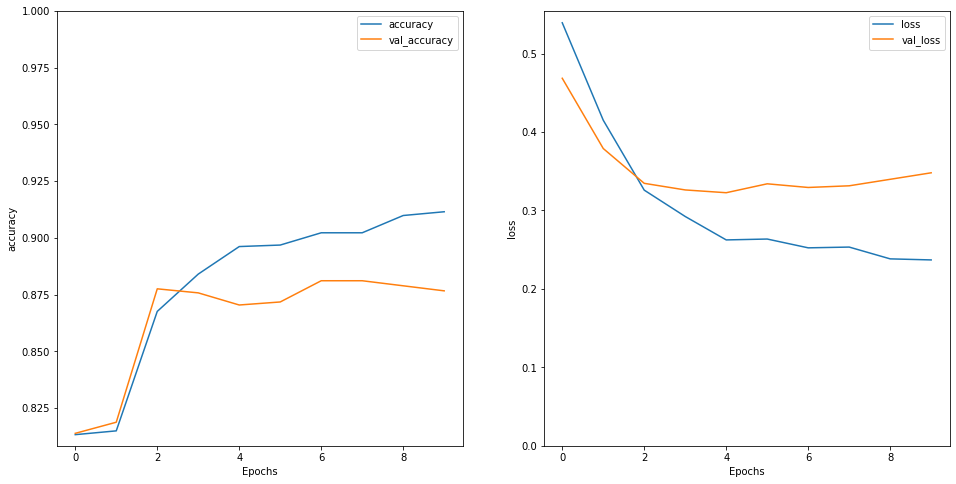

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
# Confusion matrix 
y_pred = model(text_test)
y_pred = y_pred > 0.5
print("Confusion matrix:")
print(confusion_matrix(target_test, y_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(target_test, y_pred)*100))

Confusion matrix:
[[1298   91]
 [ 136  181]]
Accuracy: 86.69%


In [ ]:
# Precision score 
print('Precision: %.3f' % precision_score(target_test, y_pred))

Precision: 0.665


In [ ]:
# Recall score 
print('Recall: %.3f' % recall_score(target_test, y_pred))

Recall: 0.571


In [ ]:
# F1 Score 
print('F1 Score: %.3f' % f1_score(target_test, y_pred))

F1 Score: 0.615


In [ ]:
## SECOND MODEL ##
# We added 2 layers 

model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(Train_dataset, epochs=10,
                    validation_data=Test_dataset,
                    validation_steps=30)

Epoch 1/10
323/323 [==============================] - 40s 68ms/step - loss: 0.5318 - accuracy: 0.8141 - val_loss: 0.4548 - val_accuracy: 0.8200
Epoch 2/10
323/323 [==============================] - 21s 65ms/step - loss: 0.3968 - accuracy: 0.8178 - val_loss: 0.3543 - val_accuracy: 0.8344
Epoch 3/10
323/323 [==============================] - 15s 48ms/step - loss: 0.3154 - accuracy: 0.8714 - val_loss: 0.3231 - val_accuracy: 0.8800
Epoch 4/10
323/323 [==============================] - 15s 47ms/step - loss: 0.2853 - accuracy: 0.8904 - val_loss: 0.3209 - val_accuracy: 0.8789
Epoch 5/10
323/323 [==============================] - 15s 48ms/step - loss: 0.2708 - accuracy: 0.8992 - val_loss: 0.3224 - val_accuracy: 0.8867
Epoch 6/10
323/323 [==============================] - 15s 47ms/step - loss: 0.2563 - accuracy: 0.9053 - val_loss: 0.3262 - val_accuracy: 0.8856
Epoch 7/10
323/323 [==============================] - 15s 47ms/step - loss: 0.2507 - accuracy: 0.9058 - val_loss: 0.3305 - val_accuracy:

In [ ]:
test_loss, test_acc = model2.evaluate(Test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

57/57 [==============================] - 1s 16ms/step - loss: 0.3413 - accuracy: 0.8816
Test Loss: 0.341301828622818
Test Accuracy: 0.8815943598747253


In [ ]:
# predict on a sample text without padding

sample_text = ('Thank you to everyone who has bought a charity phone case so far to support the wildlife victims of Australia’s worst ever…')
predictions = model2(np.array([sample_text]))
print(predictions)

tf.Tensor([[-4.733909]], shape=(1, 1), dtype=float32)


In [ ]:
# predict on a sample text with padding

padding = "you" * 2000
predictions = model2(np.array([sample_text, padding]))
print(predictions[0])

In [ ]:
sample_text = ('Thank you to everyone who has bought a charity phone case so far to support the wildlife victims of Australia’s worst ever…')
predictions = model2(np.array([sample_text]))

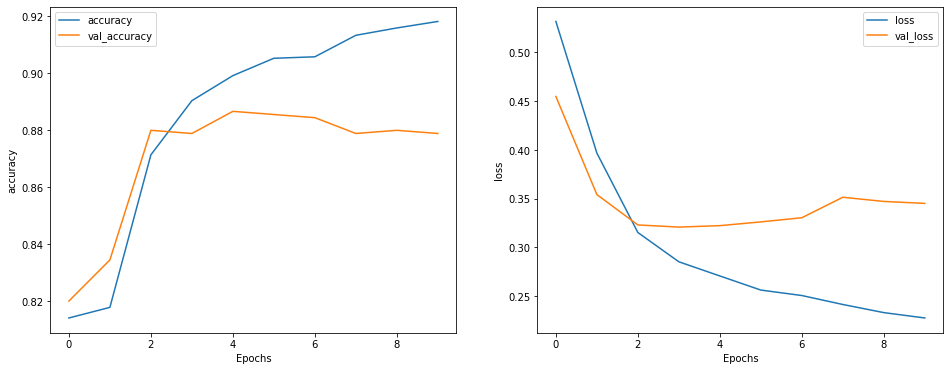

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history2, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history2, 'loss')

In [ ]:
# Confusion matrix model 2
y_pred = model2(text_test)
y_pred = y_pred > 0.5
print("Confusion matrix:")
print(confusion_matrix(target_test, y_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(target_test, y_pred)*100))

Confusion matrix:
[[1337   52]
 [ 150  167]]
Accuracy: 88.16%


In [ ]:
# Precision score model 2
print('Precision: %.3f' % precision_score(target_test, y_pred))

Precision: 0.763


In [ ]:
# Recall score model 2
print('Recall: %.3f' % recall_score(target_test, y_pred))

Recall: 0.527


In [ ]:
# F1 Score model 2
print('F1 Score: %.3f' % f1_score(target_test, y_pred))

F1 Score: 0.623
